# **Unmanned Aerial Vehical Delivery system**

#importing libraries

In [1]:
pip install selenium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 476.0/476.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.2 MB/s eta 0:00:00


In [ ]:
pip install openai==0.28

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 2.3 MB/s eta 0:00:00


In [ ]:
import folium
import random
import networkx as nx
from shapely.geometry import LineString, Polygon
import numpy as np
from queue import PriorityQueue
import time
import numpy as np
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import cv2
import os
from selenium import webdriver
import re

#using coordinates for the region we are working on

In [ ]:
# Coordinates for the corners of the main square
c1 = (33.257833, -97.178783)  # 33°15'40.2"N 97°10'43.7"W
c2 = (33.257583, -97.090917)  # 33°15'39.3"N 97°05'27.3"W
c3 = (33.184682, -97.090917)
c4 = (33.184682, -97.178783)

# Define latitude and longitude ranges based on the corners of the main square
min_lat = min(c1[0], c2[0], c3[0], c4[0])
max_lat = max(c1[0], c2[0], c3[0], c4[0])
min_lon = min(c1[1], c2[1], c3[1], c4[1])
max_lon = max(c1[1], c2[1], c3[1], c4[1])

#creating the map

In [ ]:
# Create a map centered around Denton
denton_city_map = folium.Map(location=[33.2148, -97.1331], zoom_start=12)

# Define the coordinates for the main square
square_coordinates = [c1, c2, c3, c4]

# Create a polygon using the main square coordinates
square = Polygon(square_coordinates)



#finding drones with low battery

In [ ]:
def find_low_battery_drones(drones):
    drones_with_low_batery = [drone['name'] for drone in drones if drone['battery'] < 40]
    return drones_with_low_batery

#lat and lon to grid coordinates

In [ ]:
def lat_lon_to_grid(lat, lon):
    x = int((lat - min_lat) / (max_lat - min_lat) * grid_size)
    y = int((lon - min_lon) / (max_lon - min_lon) * grid_size)
    return (x, y)

#finding nearest store

In [ ]:
def find_nearest_store(end_cell, locations):
      dist = [euclidean(end_cell, store) for store in locations]
      store_index = np.argmin(dist)
      return store_locations[store_index]

#finding nearest charging station to recharge

In [ ]:
def find_nearest_station(drone_location, station_locations):
    station_grid = [lat_lon_to_grid(station['location'][0], station['location'][1]) for station in station_locations]
    dist = [np.linalg.norm(np.array(drone_location) - np.array(loc)) for loc in station_grid]
    station_index = np.argmin(dist)
    return station_grid[station_index]

#drone charging simulation

In [ ]:
def simulate_drone_movement(drone, locations):
    with open('print_outputs.txt', 'w') as f:
      real_loc = drone['location']
      f.write(f"{drone['name']} at grid location {real_loc}. Searching for nearest charging station...\n")

      station_near = find_nearest_station(real_loc, locations)

      f.write(f"{drone['name']} moving to nearest charging station at grid location {station_near}.\n")
      drone['location'] = station_near
      time.sleep(1)

      f.write(f"{drone['name']} charging at the station...\n")
      x = drone['battery']
      drone['battery'] = 100
      f.write(f"battery charged: {100-x}'%\n")
      time.sleep(1)
      drone['status'] = 'active'

      f.write(f"{drone['name']} returning to original location at grid location {real_loc}.\n")
      drone['location'] = real_loc
      time.sleep(1)

      f.write(f"{drone['name']} is back at location and fully charged.\n")

#euclidean distance between a and b

In [ ]:
def heuristic(a, b):
    x = abs(b[0] - a[0])
    y = abs(b[1] - a[1])
    return x + y - min(x, y)

#A* algorithm for least cost with diagonals

In [ ]:
def least_cost_path_with_diagonals_and_cost(grid, start, end):
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0), (-1, -1), (-1, 1), (1, -1), (1, 1)]
    closed_set = set()
    previous_nodes = {}
    g_scores = {start: 0}
    f_scores = {start: heuristic(start, end)}
    open_heap = PriorityQueue()
    open_heap.put((f_scores[start], start))

    while not open_heap.empty():
        current_node = open_heap.get()[1]

        if current_node == end:
            path = []
            total_cost = 0
            while current_node in previous_nodes:
                path.append(current_node)
                current_node = previous_nodes[current_node]
                if path:
                    total_cost += grid[path[-1][0]][path[-1][1]]
            path.reverse()
            path.insert(0, start)
            total_cost += grid[start[0]][start[1]]
            return path, total_cost

        closed_set.add(current_node)
        for x_offset, y_offset in directions:
            neighbor_node = current_node[0] + x_offset, current_node[1] + y_offset
            if 0 <= neighbor_node[0] < grid.shape[0] and 0 <= neighbor_node[1] < grid.shape[1]:
                if x_offset == 0 or y_offset == 0:
                    movement_cost = grid[neighbor_node[0]][neighbor_node[1]]
                else:
                    movement_cost = grid[neighbor_node[0]][neighbor_node[1]] + 1

                tentative_g_score = g_scores[current_node] + movement_cost

                if neighbor_node in closed_set and tentative_g_score >= g_scores.get(neighbor_node, 0):
                    continue

                if tentative_g_score < g_scores.get(neighbor_node, 0) or neighbor_node not in [i[1] for i in open_heap.queue]:
                    previous_nodes[neighbor_node] = current_node
                    g_scores[neighbor_node] = tentative_g_score
                    f_scores[neighbor_node] = tentative_g_score + heuristic(neighbor_node, end)
                    open_heap.put((f_scores[neighbor_node], neighbor_node))

    return None


#MAP GENERATION

In [ ]:
import folium
import random

# Define the grid size
grid_size = 50

# Define the number of each type of cell
num_stores = 20
num_customers = 50
num_nfzs = 300
num_stations = 10

# Create a Folium map object centered on the main square
denton_map = folium.Map(location=[(max_lat + min_lat) / 2, (max_lon + min_lon) / 2], zoom_start=14)

# Calculate the step size for each grid cell
lat_step = (max_lat - min_lat) / grid_size
lon_step = (max_lon - min_lon) / grid_size

# Draw the grid on the map by adding lines
for i in range(grid_size + 1):
    folium.PolyLine([(min_lat + i * lat_step, min_lon), (min_lat + i * lat_step, max_lon)], color='grey', weight=1).add_to(denton_map)
    folium.PolyLine([(min_lat, min_lon + i * lon_step), (max_lat, min_lon + i * lon_step)], color='grey', weight=1).add_to(denton_map)

# Initialize the grid with +1 for all cells
grid = [[1 for _ in range(grid_size)] for _ in range(grid_size)]

# Generate all possible grid cell center points
all_grid_cells = [(min_lat + i * lat_step + lat_step / 2, min_lon + j * lon_step + lon_step / 2)
                  for i in range(grid_size) for j in range(grid_size)]

# Shuffle the list of grid cells and then take the first N cells for each type
random.shuffle(all_grid_cells)
store_cells = all_grid_cells[:num_stores]
customer_cells = all_grid_cells[num_stores:num_stores+num_customers]
nfz_cells = all_grid_cells[num_stores+num_customers:num_stores+num_customers+num_nfzs]
station_cells = all_grid_cells[num_stores+num_customers+num_nfzs:num_stores+num_customers+num_nfzs+num_stations]

# Convert grid indices back to latitude and longitude (placeholders for actual conversion)
store_locations = [{'type': 'store', 'location': (index[0], index[1])} for index in store_cells]
customer_locations = [{'type': 'customer', 'location': (index[0], index[1])} for index in customer_cells]
station_locations = [{'type': 'station', 'location': (index[0], index[1])} for index in station_cells]

# Initialize the grid with 'o' for all cells
char_grid = [['.' for _ in range(grid_size)] for _ in range(grid_size)]

# Update the char_grid with 's' for store cells
for cell in store_cells:
    i = int((cell[0] - min_lat) / lat_step)
    j = int((cell[1] - min_lon) / lon_step)
    char_grid[i][j] = 's'

# Update the char_grid with 'c' for customer cells
for cell in customer_cells:
    i = int((cell[0] - min_lat) / lat_step)
    j = int((cell[1] - min_lon) / lon_step)
    char_grid[i][j] = 'c'

for cell in station_cells:
    i = int((cell[0] - min_lat) / lat_step)
    j = int((cell[1] - min_lon) / lon_step)
    char_grid[i][j] = 'st'

# Print or use the char_grid as needed
for row in char_grid:
    print(' '.join(row))

# Update the grid with +10 for no-fly zones
for cell in nfz_cells:
    i = int((cell[0] - min_lat) / lat_step)
    j = int((cell[1] - min_lon) / lon_step)
    grid[i][j] = 10

# Place the stores, customers,stations and no-fly zones on the map
# Stores will be green markers
for cell in store_cells:
    folium.Marker(location=cell, icon=folium.Icon(color='green'), tooltip='Store').add_to(denton_map)

# Customers will be blue markers
for cell in customer_cells:
    folium.Marker(location=cell, icon=folium.Icon(color='blue'), tooltip='Customer').add_to(denton_map)

# Customers will be blue markers
for cell in station_cells:
    folium.Marker(location=cell, icon=folium.Icon(color='red'), tooltip='station').add_to(denton_map)


# No-fly zones will be red squares
for cell in nfz_cells:
    nfz_corner_lat = cell[0] - lat_step / 2
    nfz_corner_lon = cell[1] - lon_step / 2
    folium.Rectangle(
        bounds=[(nfz_corner_lat, nfz_corner_lon),
                (nfz_corner_lat + lat_step, nfz_corner_lon + lon_step)],
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.5
    ).add_to(denton_map)

# Save the map to an HTML file or display it
denton_map


. . . . . . . . . . . . . . . . . . . . . . . . . . . . s . . . st . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . s . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . c . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . c . . . . . . . . . s . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . s
. . . . . . . . . . . . . . . . . c . . . . . . . . . . . . . . . . . . . . . . . . . . . . . s . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . c . st . . . . . . . . . . . c . . . . . . . . . . . . . . . . . . . . . . . . . 

#DRONE INITIALIZATION

In [ ]:
drones = []
for x, c in enumerate(store_cells):
    gi = int((c[0] - min_lat) / lat_step)
    gj = int((c[1] - min_lon) / lon_step)
    drones.append({
        'name': f'Drone_{x + 1}',
        'location': (gi, gj),
        'battery': 100,
        'status' : 'active'
    })

for drone in drones:
    print(f"{drone['name']} : grid position {drone['location']} : {drone['battery']}% battery : status {drone['status']}")

Drone_1 : grid position (48, 14) : 100% battery : status active
Drone_2 : grid position (24, 13) : 100% battery : status active
Drone_3 : grid position (22, 1) : 100% battery : status active
Drone_4 : grid position (20, 14) : 100% battery : status active
Drone_5 : grid position (37, 21) : 100% battery : status active
Drone_6 : grid position (41, 15) : 100% battery : status active
Drone_7 : grid position (46, 47) : 100% battery : status active
Drone_8 : grid position (22, 8) : 100% battery : status active
Drone_9 : grid position (36, 18) : 100% battery : status active
Drone_10 : grid position (29, 15) : 100% battery : status active
Drone_11 : grid position (4, 23) : 100% battery : status active
Drone_12 : grid position (24, 40) : 100% battery : status active
Drone_13 : grid position (45, 47) : 100% battery : status active
Drone_14 : grid position (5, 49) : 100% battery : status active
Drone_15 : grid position (0, 28) : 100% battery : status active
Drone_16 : grid position (32, 1) : 100%

#initializing battery tracking dictionary

In [ ]:
battery_tracking = {i['name']: [] for i in drones}
profits = []

In [ ]:
battery_tracking

{'Drone_1': [],
 'Drone_2': [],
 'Drone_3': [],
 'Drone_4': [],
 'Drone_5': [],
 'Drone_6': [],
 'Drone_7': [],
 'Drone_8': [],
 'Drone_9': [],
 'Drone_10': [],
 'Drone_11': [],
 'Drone_12': [],
 'Drone_13': [],
 'Drone_14': [],
 'Drone_15': [],
 'Drone_16': [],
 'Drone_17': [],
 'Drone_18': [],
 'Drone_19': [],
 'Drone_20': []}

#DRONE SIMULATION

In [ ]:
with open('output_logs.txt', 'w') as log_file:
    iteration_counter = 0
    for iteration in range(70):
        # Randomly select start and end positions from 's' and 'c' cells
        start_position = random.choice([(i, j) for i in range(grid_size) for j in range(grid_size) if char_grid[i][j] == 's'])
        end_position = random.choice([(i, j) for i in range(grid_size) for j in range(grid_size) if char_grid[i][j] == 'c'])
        grid = np.array(grid)
        # Find least cost path including diagonal movement and calculate total cost
        path, total_cost = least_cost_path_with_diagonals_and_cost(grid, start_position, end_position)
        log_file.write(f"Start position: {start_position}\n")
        log_file.write(f"End position: {end_position}\n")
        log_file.write(f"Least cost path with diagonals: {path}\n")
        log_file.write(f"Total cost of the path: {total_cost}\n")
        profits.append(total_cost)
        # Update drone based on path cost
        for drone in drones:
            battery_tracking[drone['name']].append(drone['battery'])
            if drone['location'] == start_position:
                drone['location'] = end_position
                drone['battery'] -= total_cost / 2
                battery_tracking[drone['name']].append(drone['battery'])
                break

        # Changing drone status to inactive if battery is less than 40%
        for drone in drones:
            if drone['battery'] < 40:
                drone['status'] = 'inactive'
        for drone in drones:
            log_file.write(f"{drone}\n")

        # Calculate the latitude and longitude step size for each grid cell
        latitude_step_size = (max_lat - min_lat) / grid_size
        longitude_step_size = (max_lon - min_lon) / grid_size

        # Convert grid cell indices in the path to latitude and longitude coordinates
        path_coordinates = [(min_lat + cell[0] * latitude_step_size + latitude_step_size / 2,
                            min_lon + cell[1] * longitude_step_size + longitude_step_size / 2) for cell in path]

        # Draw the path on the map with tooltips and random dark color (excluding red)
        for i in range(len(path_coordinates) - 1):
            start_point = path_coordinates[i]
            end_point = path_coordinates[i + 1]
            path_info = f"From: {start_point}\nTo: {end_point} ......Total Cost {total_cost}....Fuel Consumption : {total_cost/2}%"  # Customize the tooltip content as needed

            # Generate random dark RGB values for the color (excluding red)
            color = "#{:02x}{:02x}{:02x}".format(random.randint(0, 127), random.randint(0, 127), random.randint(0, 127))
            folium.PolyLine([start_point, end_point], color=color, weight=2, tooltip=path_info).add_to(denton_map)

        # Assuming you have the store locations stored in a list called 'store_locations'
        store_locations = [(i, j) for i in range(grid_size) for j in range(grid_size) if char_grid[i][j] == 's']

        # Example usage
        nearest_store = find_nearest_store(end_position, store_locations)
        log_file.write(f"Nearest store from end position: {nearest_store}\n")
        path_return, total_cost = least_cost_path_with_diagonals_and_cost(grid, end_position, nearest_store)
        log_file.write(f"Start position: {end_position}\n")
        log_file.write(f"Nearest store position: {nearest_store}\n")
        log_file.write(f"Least cost path with diagonals: {path_return}\n")
        log_file.write(f"Total cost of the path: {total_cost}\n")
        profits.append(total_cost)
        for drone in drones:
            if drone['location'] == end_position:
                drone['location'] = nearest_store
                drone['battery'] -= total_cost / 2
                break

        # Calculate the latitude and longitude step size for each grid cell
        latitude_step_size = (max_lat - min_lat) / grid_size
        longitude_step_size = (max_lon - min_lon) / grid_size

        # Convert grid cell indices in the path to latitude and longitude coordinates
        path_coordinates_return = [(min_lat + cell[0] * latitude_step_size + latitude_step_size / 2,
                                    min_lon + cell[1] * longitude_step_size + longitude_step_size / 2) for cell in path_return]

        for drone in drones:
            if drone['battery'] < 40:
                log_file.write(f"{drone['name']}\n")
                simulate_drone_movement(drone, station_locations)

        # Draw the return path on the map with tooltips
        for i in range(len(path_coordinates_return) - 1):
            start_point_return = path_coordinates_return[i]
            end_point_return = path_coordinates_return[i + 1]
            path_info_return = f"From: {start_point_return}\nTo: {end_point_return}"  # Customize the tooltip content as needed
            folium.PolyLine([start_point_return, end_point_return], color='red', weight=2, tooltip=path_info_return).add_to(denton_map)

       # denton_map.save(f'snapshots/map_snapshot_{iteration_counter}.html')
        iteration_counter += 1

print("Output logs saved to 'output_logs.txt'.")


Output logs saved to 'output_logs.txt'.


# KDE plot of profits

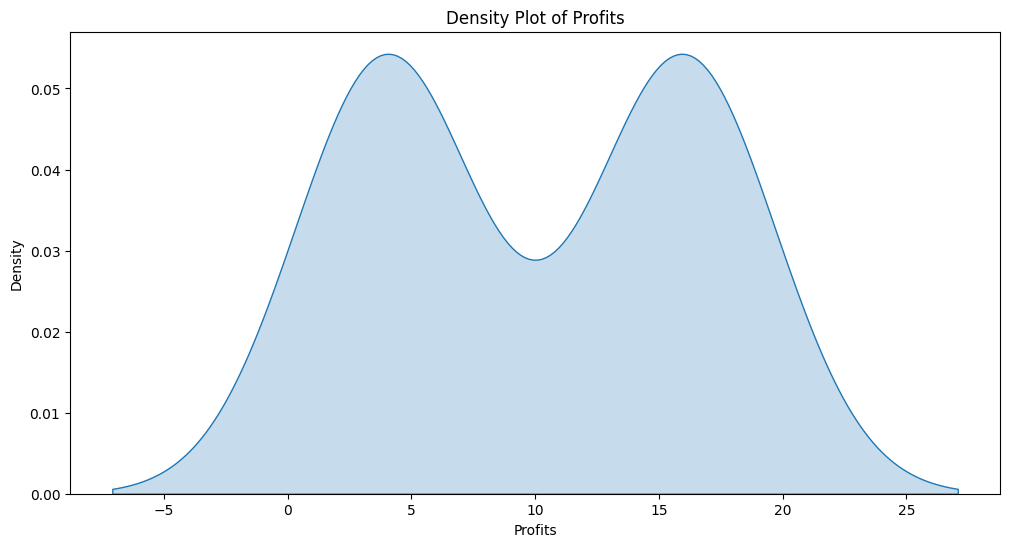

In [ ]:
import seaborn as sns

# Using Seaborn to plot a KDE plot
plt.figure(figsize=(12, 6))
sns.kdeplot(profits, bw_adjust=0.5, fill=True)  # 'bw_adjust' controls the smoothness of the curve
plt.title('Density Plot of Profits')
plt.xlabel('Profits')
plt.ylabel('Density')
plt.show()


In [ ]:
battery_tracking

{'Drone_1': [100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  84.5,
  83.5,
  83.5,
  83.5,
  83.5,
  83.5,
  83.5,
  83.5,
  69.0,
  63.5,
  63.5,
  63.5,
  63.5,
  63.5,
  63.5,
  63.5,
  63.5,
  63.5,
  63.5,
  63.5,
  63.5,
  54.5,
  52.5,
  52.5,
  52.5,
  50.0,
  48.5,
  48.5,
  48.5,
  48.5,
  48.5,
  48.5,
  48.5,
  48.5,
  48.5,
  48.5,
  48.5,
  48.5,
  48.5,
  42.0,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  100,
  85.5,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0,
  80.0],
 'Drone_2': [100,
  100,
  81.5,
  79.0,
  71.0,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67.5,
  67

#TIME SERIES PLOT OF EACH DRONES BATTERY VS ELAPSED TIME

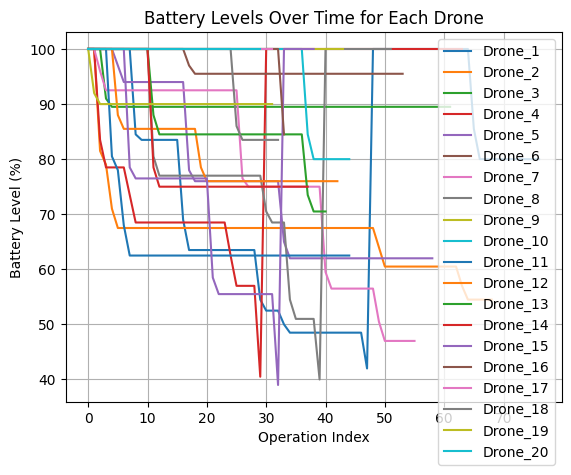

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'battery_tracking' is a dictionary with drone names as keys and lists of battery levels as values
for drone, batteries in battery_tracking.items():
    plt.plot(batteries, label=drone)

plt.title('Battery Levels Over Time for Each Drone')
plt.xlabel('Operation Index')
plt.ylabel('Battery Level (%)')
plt.legend()
plt.grid(True)
plt.show()


#HEATMAP OF BATTERY LEVELS

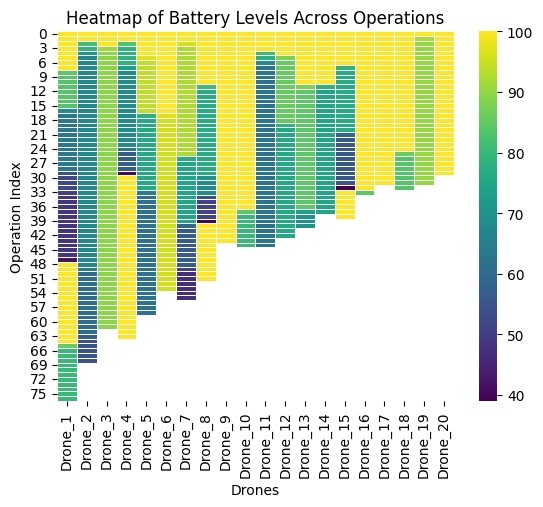

In [ ]:
import seaborn as sns
import pandas as pd

# Convert the battery_tracking dictionary into a DataFrame for easier plotting
df = pd.DataFrame.from_dict(battery_tracking, orient='index').transpose()
sns.heatmap(df, annot=False, cmap='viridis', linewidths=.5)
plt.title('Heatmap of Battery Levels Across Operations')
plt.xlabel('Drones')
plt.ylabel('Operation Index')
plt.show()


#FINAL MAP


In [ ]:
denton_map

In [ ]:
'''
import openai

def split_text(text, max_length=127000):
    words = text.split()
    segments = []
    current_segment = []
    for word in words:
        if len(' '.join(current_segment + [word])) > max_length:
            segments.append(' '.join(current_segment))
            current_segment = [word]
        else:
            current_segment.append(word)
    if current_segment:
        segments.append(' '.join(current_segment))
    return segments
def summarize_text(segments, api_key):
    summaries = []
    engine = "gpt-4-turbo"  # Ensure this is the correct model
    openai.api_key = api_key
    for segment in segments:
        prompt = "Summarize the following text and give a table type data:\n" + segment
        try:
            response = openai.ChatCompletion.create(
                model=engine,
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": prompt}
                ]
            )
            summary = response['choices'][0]['message']['content'].strip()
            summaries.append(summary)
        except Exception as e:
            summaries.append(f"An error occurred: {str(e)}")
            continue

    return summaries

def main():
    file_path = 'print_outputs.txt'
    api_key = ''  # Place your API key here securely

    try:
        with open(file_path, 'r') as file:
            text = file.read()

        segments = split_text(text)
        summaries = summarize_text(segments, api_key)

        print("Generated Summaries:")
        for summary in summaries:
            print(summary)
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' does not exist.")

if __name__ == "__main__":
    main()
'''

'\nimport openai\n\ndef split_text(text, max_length=127000):\n    words = text.split()\n    segments = []\n    current_segment = []\n    for word in words:\n        if len(\' \'.join(current_segment + [word])) > max_length:\n            segments.append(\' \'.join(current_segment))\n            current_segment = [word]\n        else:\n            current_segment.append(word)\n    if current_segment:\n        segments.append(\' \'.join(current_segment))\n    return segments\ndef summarize_text(segments, api_key):\n    summaries = []\n    engine = "gpt-4-turbo"  # Ensure this is the correct model\n    openai.api_key = api_key\n    for segment in segments:\n        prompt = "Summarize the following text and give a table type data:\n" + segment\n        try:\n            response = openai.ChatCompletion.create(\n                model=engine,\n                messages=[\n                    {"role": "system", "content": "You are a helpful assistant."},\n                    {"role": "user", "